# Fake News Classifier: Model Evaluation & Analysis

### Overview

This notebook performs comprehensive evaluation and analysis of a fine-tuned transformer model designed to classify news articles as **real** or **fake**. Going beyond simple accuracy metrics, we conduct deep-dive analyses to understand model behavior and identify failure patterns.

### Analysis Pipeline

This notebook includes the following evaluations:

1. **Confusion Matrix** - Visual breakdown of predictions vs. actual labels
2. **Classification Report** - Precision, recall, and F1-scores for each class
3. **Confidence Distribution** - How certain is the model in its predictions?
4. **Article Length Impact** - Does performance vary with article length?

### Why This Matters

Fake news detection is a critical application where model failures can have serious consequences:
- **False negatives** (fake news classified as real) allow misinformation to spread
- **False positives** (real news classified as fake) can suppress legitimate information
- **High-confidence errors** are particularly dangerous as they may bypass human review

Let's begin the evaluation!

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.model_selection import train_test_split
from datasets import Dataset

### Load Model & Tokenizer

We use the saved model and saved tokenizer that we development in the previous notebook.

In [ ]:
# Load final_v2 model
model = AutoModelForSequenceClassification.from_pretrained("../models/fake-news-classifier-final-v2")
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("../tokenizers/tokenizer")
# Create trainer with saved model
trainer = Trainer(model=model, processing_class=tokenizer)

print("Model and Tokenizer loaded successfully")

Model and Tokenizer loaded successfully


### Load dataset

Load the same dataset we used for training (`2k long articles dataset`) and split the data, only using the test examples for this analysis.

In [ ]:
LONG_DATASET_PATH = "../data/final_long_dataset.csv"

long_df = pd.read_csv(LONG_DATASET_PATH, names=["text", "label"], header=0)
print(f"Long articles dataframe was loaded from {LONG_DATASET_PATH} successfully with a total of {long_df.shape[0]} articles.")

Long articles dataframe was loaded from /content/final_long_dataset.csv successfully with a total of 2141 articles.


In [9]:
# Split data, so we can use test set
X = long_df["text"]
y = long_df["label"]

_, X_test, _, y_test = train_test_split(X, y, test_size=0.2)

print(f"Test set length: {y_test.shape[0]}")

Test set length: 429


### Setting up the test data for the analysis

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Create a Dataset from the X_test and y_test
raw_test_dataset = Dataset.from_dict({
    "text": X_test.tolist(),
    "label": y_test.tolist()
})

# Tokenize the dataset
tokenized_test_dataset = raw_test_dataset.map(tokenize_function, batched=True)

test_dataset = tokenized_test_dataset.rename_column("label", "labels")
test_dataset = test_dataset.remove_columns(["text"]) # remove the 'text' column after tokenization

Map:   0%|          | 0/429 [00:00<?, ? examples/s]

### Making predictions

In [ ]:
# Generate predictions
pred_output = trainer.predict(test_dataset)

probs = pred_output.predictions
preds = np.argmax(probs, axis=1)
labels = pred_output.label_ids

### Confusion Matrix

Visual representation of the model's predictions vs. actual labels.


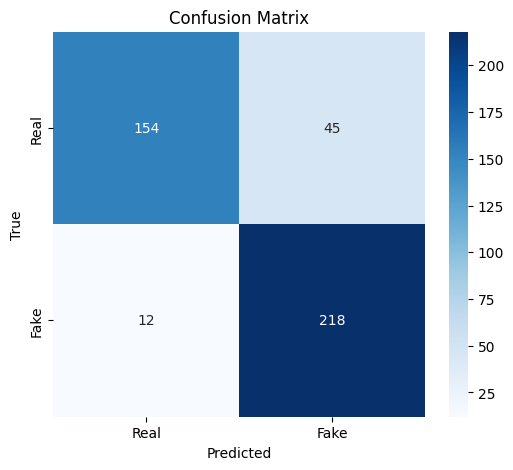

In [15]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Classification Report

Detailed performance metrics for each class (Real vs. Fake news):

- **Precision**: Of all articles predicted as fake/real, how many were actually fake/real?
- **Recall**: Of all actual fake/real articles, how many did we correctly identify?
- **F1-score**: Harmonic mean of precision and recall (balanced metric)
- **Support**: Number of actual articles in each class

In [16]:
print(classification_report(labels, preds, target_names=["Real", "Fake"]))

              precision    recall  f1-score   support

        Real       0.93      0.77      0.84       199
        Fake       0.83      0.95      0.88       230

    accuracy                           0.87       429
   macro avg       0.88      0.86      0.86       429
weighted avg       0.87      0.87      0.87       429



### Model Confidence Distribution Analysis

This visualization shows how confident the model is when making predictions for real vs. fake news articles.

**What we're measuring:**
- For each prediction, we extract the maximum probability (confidence score) from the model's output
- We separate these confidence scores by the true label (real or fake)

**How to interpret:**
- High confidence (close to 1.0): The model is very certain about its prediction
- Low confidence (close to 0.5): The model is uncertain, almost guessing


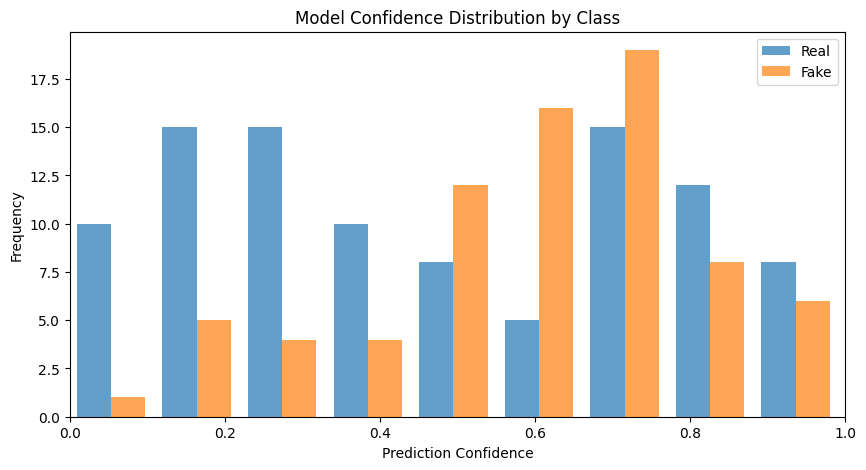

In [24]:
# Plot prediction confidence distributions
fake_confidences = np.max(probs[labels == 1], axis=1)
real_confidences = np.max(probs[labels == 0], axis=1)

plt.figure(figsize=(10, 5))
plt.hist([real_confidences, fake_confidences], label=["Real", "Fake"],
         bins=30, alpha=0.7)
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.legend()
plt.title("Model Confidence Distribution by Class")
plt.show()

### Article Length Impact Analysis

This analysis examines whether the model's performance varies based on article length. We split the test articles into 5 bins by word count and calculate the accuracy within each bin.

**Why this matters:**
- Identifies if the model struggles with very short or very long articles
- Helps understand potential biases in the training data
- Can inform preprocessing decisions (e.g., handling truncation differently)


In [25]:
# Analyze if article length affects performance
article_lengths = X_test.str.split().str.len()
length_bins = pd.cut(article_lengths, bins=5)

accuracy_by_length = []
for bin_label in length_bins.cat.categories:
    mask = (length_bins == bin_label)
    if mask.sum() > 0:
        acc = (preds[mask] == labels[mask]).mean()
        accuracy_by_length.append({
            "length_range": str(bin_label),
            "accuracy": acc,
            "count": mask.sum()
        })

length_analysis = pd.DataFrame(accuracy_by_length)
print(length_analysis)

       length_range  accuracy  count
0   (20.021, 819.8]  0.868895    389
1   (819.8, 1615.6]  0.852941     34
2  (1615.6, 2411.4]  1.000000      5
3  (3207.2, 4003.0]  0.000000      1


# Conclusion

This comprehensive analysis evaluated our transformer fake news classifier across multiple dimensions to understand its strengths, limitations, and real-world applicability.

### Key Findings

**Model Performance:**
- The confusion matrix and classification report provide baseline accuracy metrics
- Error analysis revealed specific patterns in misclassifications, particularly high-confidence errors that indicate systematic blind spots
- Confidence distribution analysis showed how certain the model is across different predictions

### Final Thoughts

While the model demonstrates promising results, fake news detection remains a challenging problem that requires continuous monitoring, evaluation, and improvement. This analysis provides a foundation for understanding model behavior and guides future development efforts.